In [1]:
import torch
from src.models.cvae import CVAE  # モデルのクラス

# パラメータ設定
input_channels = 3  # RGB画像
latent_dim = 64
conditional_dim = 2
img_size = 224

# モデルのインスタンス化と重みの読み込み
model = CVAE(input_channels, img_size, latent_dim, conditional_dim)
model.load_state_dict(torch.load('trained_model.pth'))
model.to('mps')  # CPUで推論する場合
model.eval()  # 推論モードに設定

# 潜在変数のサンプリング
z = torch.randn(1, latent_dim)  # ランダムな潜在変数
c = torch.tensor([[0.25, 1]])  # 条件変数（例: 性別、年齢など）

# 画像の生成
with torch.no_grad():
    generated_img = model.decode(z, c)


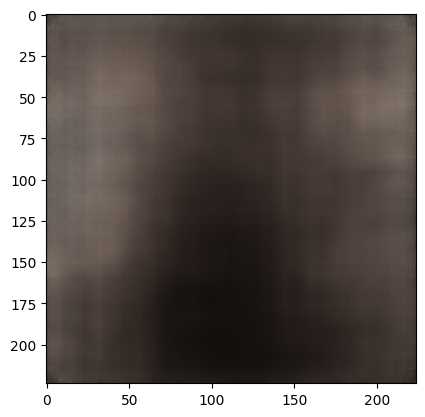

In [5]:
import matplotlib.pyplot as plt

plt.imshow(generated_img[0].permute(1, 2, 0) * 255)

In [15]:
import torch
import plotly.express as px
import plotly.graph_objects as go
from src.data.lagenda import LagendaDataset
from src.data.transform import get_transforms

model.to('mps')

# データセットの読み込みと潜在変数の抽出
# 例えば dataset がデータセットのインスタンスであるとする
latent_variables = []
ages = []
genders = []
images = []

transfrom = get_transforms()
dataset = LagendaDataset(csv_file='data/lagenda_annotation.csv', root_dir='data/', transform=transfrom)
for data in dataset:
    image, age, gender = data['image'], data['age'], data['gender']
    image = image.to('mps')
    conditions = torch.tensor([[age, gender]]).to('mps')

    with torch.no_grad():
        z, _ = model.encode(image.unsqueeze(0), conditions)
    latent_variables.append(z.squeeze(0).cpu().numpy())
    ages.append(age)
    genders.append('男性' if gender == 0 else '女性')
    images.append(image)


TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [16]:
# 潜在変数の可視化
fig = go.Figure()

for z, age, gender, img in zip(latent_variables, ages, genders, images):
    fig.add_trace(go.Scatter(
        x=[z[0]], y=[z[1]], 
        mode='markers', 
        marker=dict(color='blue' if gender == '男性' else 'red'),
        text=str(age),
        hoverinfo='text',
        hovertext=img.cpu().numpy()
    ))

fig.show()

ValueError: 
    Invalid value of type 'builtins.str' received for the 'hoverinfo' property of scatter
        Received value: 'text+image'

    The 'hoverinfo' property is a flaglist and may be specified
    as a string containing:
      - Any combination of ['x', 'y', 'z', 'text', 'name'] joined with '+' characters
        (e.g. 'x+y')
        OR exactly one of ['all', 'none', 'skip'] (e.g. 'skip')
      - A list or array of the above